In [28]:
import os
import cv2 as cv
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import shutil
from PIL import Image
import matplotlib.patches as patches
import io

In [29]:
total_body = 33
total_hand = 42

body_idx = list(range(11, 17))
lefthand_idx = [x+total_body for x in range(0, 21)]
righthand_idx = [x+21 for x in lefthand_idx]
total_idx = body_idx + lefthand_idx + righthand_idx 

body_count = len(body_idx)
hand_count = len(lefthand_idx)


body_connect = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]

mp_hand_connection = [(0, 1), (0, 5), (0, 17), (1, 2), (2, 3), (3, 4), (5, 6), (5, 9), (6, 7), (7, 8), (9, 10), (9, 13), (10, 11), (11, 12), (13, 14), (13, 17), (14, 15), (15, 16), (17, 18), (18, 19), (19, 20)]
lefthand_connect = [(x+total_body, y+total_body) for (x, y) in mp_hand_connection]

righthand_connect = [(x+21, y+21) for (x, y) in lefthand_connect]

body_connect = [(x-11, y-11) for (x, y) in body_connect]
lefthand_connect = [(body_count+lefthand_idx.index(x), body_count+lefthand_idx.index(y)) for (x, y) in lefthand_connect]
righthand_connect = [(body_count+righthand_idx.index(x)+21, body_count+righthand_idx.index(y)+21) for (x, y) in righthand_connect]



connection = body_connect + lefthand_connect+ righthand_connect

In [30]:
data_name = "./"

# video_dir = "./data/Phoenix-2014-T/video/"
data_dir = "./data/small_dataset/test"
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"{data_dir} not found with data_name: {data_name}")
# if not os.path.exists(video_dir):
#     raise FileNotFoundError(f"{video_dir} not found with data_name: {data_name}")

In [31]:
all_files = glob.glob(os.path.join(data_dir, '**', '*.pkl'), recursive=True)
print(len(all_files))

642


In [32]:
train_data = {}
test_data = {}
for file in tqdm(all_files):
    x = file.split("\\")
    # print(x)
    try:
        split = "test"
        file_name= x[-1]
        # print(file_name, split)
    except:
        continue
    key = f"{split}/{file_name[:-4]}"
    # video_file = f"{video_dir}/{file_name.replace('.pkl', '')}"
    
    # if not os.path.exists(video_file):
    #     print(video_file)
    #     continue
        
    sample = {
        "path" : file,
        "split": split,
    }
    if split == "train":
        train_data[key] = sample
    else:
        test_data[key] = sample

100%|██████████| 642/642 [00:00<00:00, 642966.37it/s]


In [33]:
train_key = list(train_data.keys())
test_key = list(test_data.keys())
test_key[-1]

'test/31May_2011_Tuesday_heute-1904'

In [34]:
def save_images(images, output_folder="output_images"):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    for i, img in enumerate(images):
        img_path = os.path.join(output_folder, f"frame_{i:04d}.png")
        cv.imwrite(img_path, img)


In [35]:
alpha_dict = {
        "lefthand": 0.01,    
        "righthand": 0.1, 
        "body": 0.05     
    }
def get_bbox(frame, width, height, key):
    x_coords = frame[:, 0]
    y_coords = frame[:, 1]
    min_x, min_y = min(x_coords), min(y_coords)
    max_x, max_y = max(x_coords), max(y_coords)
    w = max_x - min_x
    h = max_y - min_y
    alpha = alpha_dict[key]

    if w > h:
        delta_x = alpha * w
        delta_y = delta_x + ((w - h) / 2)
    else:
        delta_y = alpha * h
        delta_x = delta_y + ((h - w) / 2)


    starting_point = [min(min_x - delta_x, width), min(min_y - delta_y, height)]
    ending_point = [min(max_x + delta_x, width), min(max_y + delta_y, height)]
 
        
    
    temp = [int(x) for x in starting_point+ending_point]
    
    return (temp[0], temp[1]), (temp[2], temp[3])
colors = {
        "lefthand": (46, 204, 64),    
        "righthand": (255, 133, 27), 
        "body": (0, 116, 217),     
        "face": (244, 194, 194)       
    }
colors_light = {
    "lefthand": (150, 229, 159),    # nhạt hơn màu xanh lá
    "righthand": (255, 180, 140),   # nhạt hơn màu cam
    "body": (128, 186, 236),        # nhạt hơn màu xanh dương
    "face": (249, 222, 222)         # nhạt hơn màu hồng
}
def draw_keypoints_matplotlib(
    image, keypoints, connections=None, point_size=5, line_width=1, dpi=100
):

    h, w = image.shape[:2]

    # Tạo figure với kích thước tương ứng với ảnh
    fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=dpi)

    # Hiển thị ảnh nền
    ax.imshow(image)
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)  # Đảo ngược trục y để phù hợp với coordinate của ảnh
    ax.set_aspect("equal")
    ax.axis("off")

    # Keypoints cho connections
    keypoints_connect = keypoints[total_idx, :]

    # Vẽ cho từng phần
    for idx, connect, part_name in [
        (lefthand_idx, lefthand_connect, "lefthand"),
        (righthand_idx, righthand_connect, "righthand"),
        (body_idx, body_connect, "body"),
    ]:
        # Lấy keypoints của phần hiện tại
        part_kps = keypoints[idx, :]
        
        point_color = np.array(colors[part_name]) / 255.0
        line_color = np.array(colors_light[part_name]) / 255.0

        bbox = get_bbox(keypoints, w, h, part_name)
        (x1, x2), (y1, y2) = bbox
        
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        
        rect = patches.Rectangle(
            (x1, y1),
            bbox_width,
            bbox_height,
            linewidth=1,
            edgecolor=point_color,  # Dùng màu của part
            facecolor="none",  # Không tô màu bên trong
            alpha=1,
        )
        ax.add_patch(rect)
        
       

        for start_idx, end_idx in connect:
            start_point = keypoints_connect[start_idx]
            end_point = keypoints_connect[end_idx]

            ax.plot(
                [start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                color=line_color,
                linewidth=line_width,
                solid_capstyle="round",
            )

        
        ax.scatter(
            part_kps[:, 0],
            part_kps[:, 1],
            c=[point_color],
            s=point_size,
            linewidths=0.5,
            edgecolors="white",
            zorder=10,
        )

    # Chuyển đổi figure thành numpy array
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, dpi=dpi)
    buf.seek(0)

    pil_image = Image.open(buf)
    image_with_keypoints = np.array(pil_image)

    # Xử lý RGBA -> RGB nếu cần
    if image_with_keypoints.shape[2] == 4:  # RGBA
        image_with_keypoints = image_with_keypoints[:, :, :3]

    # Đóng figure để giải phóng bộ nhớ
    plt.close(fig)
    buf.close()

    return image_with_keypoints

def translate_keypoints(frames, translation_vector):   
    return frames + np.array(translation_vector)

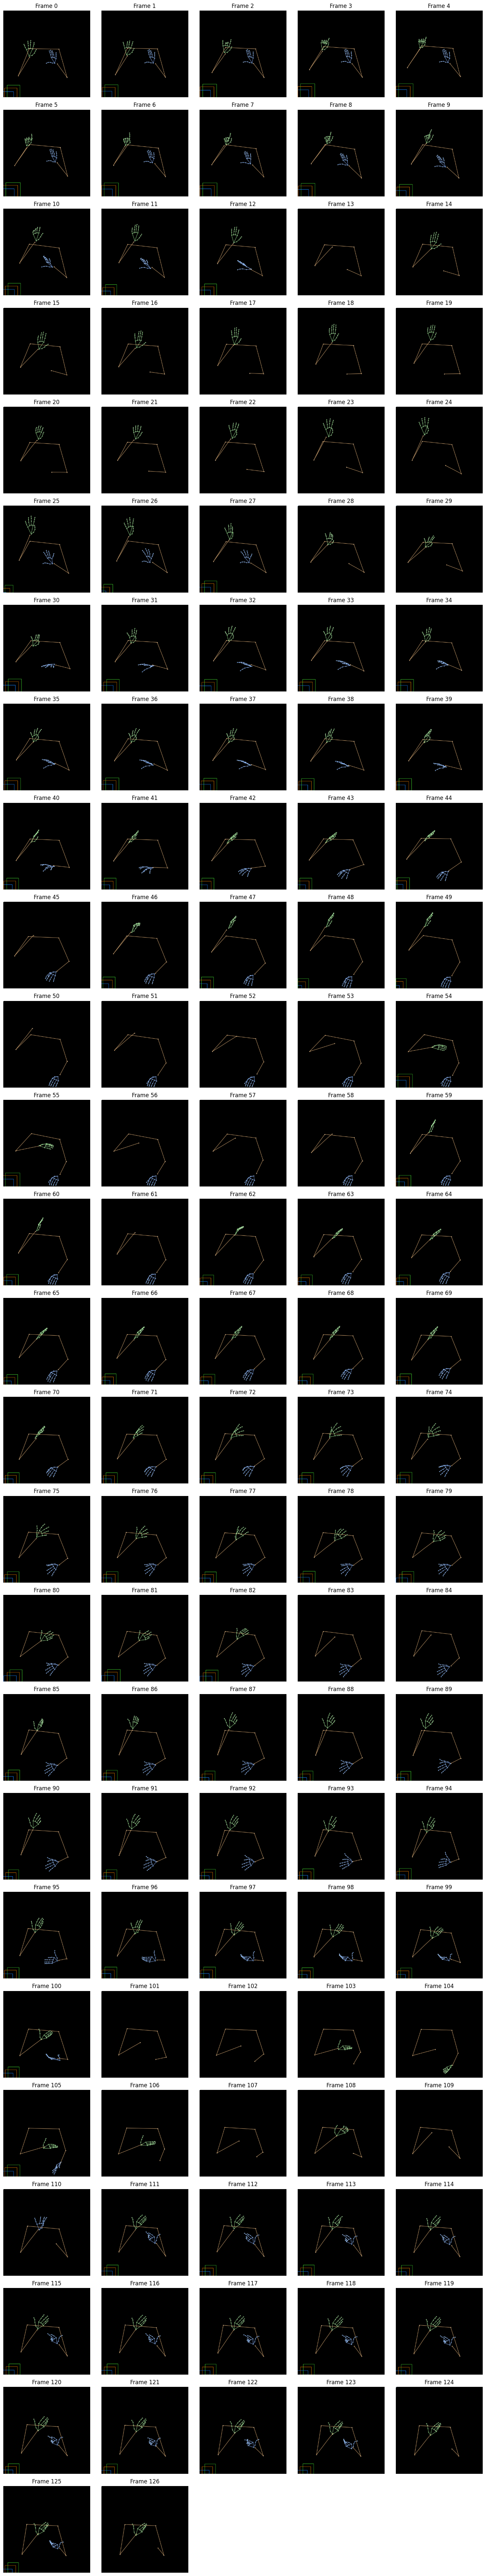

In [36]:
def show_sample(sample, key):
    path = sample["path"]
    with open(path, "rb") as f:
        data = pickle.load(f)
    
    # image_dir = f"{video_dir}//{data['name']}"
    # if not os.path.exists(image_dir):
        # print(image_dir)
        # return [], []
    
    keypoints = data["keypoints"]
    # image_paths = sorted(glob.glob(f"{image_dir}/*"))
    keypoints = keypoints[:, :, :2]
    keypoints = np.clip(keypoints, 0, 1)
    
    raw_frames = []
    annotation_frames = []
    
    # num_frames = len(image_paths)
    num_frames = len(keypoints)
    cols = 5  
    rows = (num_frames + cols - 1) // cols 
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    
    for i, p in enumerate(keypoints):
        # frame = cv.imread(p)
        frame = np.zeros((512, 512, 3), dtype=np.uint8)
        raw_frames.append(frame.copy())
        keypoint = keypoints[i]
        keypoint_frame = frame.copy()
        
        keypoint[:, 0] *= frame.shape[1]
        keypoint[:, 1] *= frame.shape[0]
        
        annotated_frame = draw_keypoints_matplotlib(
            keypoint_frame, keypoint, connection
        )
        annotated_frame = cv.resize(annotated_frame, (256, 256))
        annotation_frames.append(annotated_frame)
        
        axes[i].imshow(cv.cvtColor(annotated_frame, cv.COLOR_BGR2RGB))
        axes[i].axis("off")
        axes[i].set_title(f"Frame {i}")
    
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return raw_frames, annotation_frames, keypoints, data

# key = np.random.choice(test_key, size=1)[0]
raw_frames, annotation_frames,keypoints, data  = show_sample(test_data[key], key)
# save_images(annotation_frames, output_folder="annotation_images")

In [37]:
def create_full_keypoints_canvas_matplotlib(
    keypoints, canvas_size=(512, 512), point_size=8, line_width=1, dpi=500, **kwargs
):
    positioned_keypoints = keypoints.copy()

    fig, ax = plt.subplots(
        figsize=(canvas_size[0] / 100, canvas_size[1] / 100), dpi=dpi
    )
    ax.set_xlim(0, canvas_size[0])
    ax.set_ylim(0, canvas_size[1])
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.axis("off")
    keypoints_connect = keypoints[total_idx, :]
    
    for idx,connect, part_name in [
                            (lefthand_idx, lefthand_connect, "lefthand"),
                            (righthand_idx,righthand_connect, "righthand"),
                            (body_idx, body_connect, "body")
                            ]:
        
        line_color = np.array(colors_light[part_name]) / 255.0
        for start_idx, end_idx in connect:
            start_point = keypoints_connect[start_idx]
            end_point = keypoints_connect[end_idx]

            ax.plot(
                [start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                color=line_color,
                linewidth=line_width,
                solid_capstyle="round",
                )
        
        point_color = np.array(colors[part_name]) / 255.0
        part_keypoints = positioned_keypoints[idx, :]
        ax.scatter(
            part_keypoints[:, 0],
            part_keypoints[:, 1],
            c=[point_color],
            s=point_size,
            linewidths=1,
            zorder=10,
        )

    plt.close()

    # Chuyển đổi thành numpy array
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    buf_array = np.array(img)

    # Xử lý RGBA -> RGB nếu cần
    if buf_array.shape[2] == 4:  # RGBA
        buf_array = buf_array[:, :, :3]

    return buf_array, positioned_keypoints
def create_part_canvas_matplotlib(
    keypoints, part_name, canvas_size=(512, 512), point_size=8, line_width=1, dpi=500, **kwargs
):
    part_idx_mapping = {
        "lefthand": lefthand_idx,
        "righthand": righthand_idx,
        "body": body_idx,
    }

    part_connections_mapping = {
        "lefthand": lefthand_connect,
        "righthand": righthand_connect,
        "body": body_connect,
    }
    
    
    part_idx = part_idx_mapping[part_name]
    part_kps = keypoints[part_idx, :]
    connections = part_connections_mapping.get(part_name, [])

# Tính bbox và positioning
    x_coords = part_kps[:, 0]
    y_coords = part_kps[:, 1]
    min_x, min_y = min(x_coords), min(y_coords)
    max_x, max_y = max(x_coords), max(y_coords)
    kp_width = max_x - min_x
    kp_height = max_y - min_y

    # Căn giữa keypoints
    offset_x = (canvas_size[0] - kp_width) / 2 - min_x
    offset_y = (canvas_size[1] - kp_height) / 2 - min_y

    positioned_keypoints = part_kps.copy()
    positioned_keypoints[:, 0] += offset_x
    positioned_keypoints[:, 1] += offset_y

    # Tạo figure với DPI cao
    fig, ax = plt.subplots(
        figsize=(canvas_size[0] / 100, canvas_size[1] / 100), dpi=dpi
    )
    ax.set_xlim(0, canvas_size[0])
    ax.set_ylim(0, canvas_size[1])
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.axis("off")

    point_color = np.array(colors[part_name]) / 255.0
    line_color = np.array(colors_light[part_name]) / 255.0

    # Vẽ connections trước
    if connections:
        keypoints_connect = keypoints[total_idx, :].copy()
        keypoints_connect[:, 0] += offset_x
        keypoints_connect[:, 1] += offset_y

        for start_idx, end_idx in connections:
            start_point = keypoints_connect[start_idx]
            end_point = keypoints_connect[end_idx]

            ax.plot(
                [start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                color=line_color,
                linewidth=line_width,
                solid_capstyle="round",
                # alpha=0,
            )

    # Vẽ keypoints
    ax.scatter(
        positioned_keypoints[:, 0],
        positioned_keypoints[:, 1],
        c=[point_color],
        s=point_size,
        # alpha=,
        # edgecolors="white",
        linewidths=1,
        zorder=10,
    )

    plt.close()
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    buf = np.array(img)
    if buf.shape[2] == 4:  # RGBA
        buf = buf[:, :, :3]

    return buf, positioned_keypoints

In [38]:
def save_part_images(part_frames, part_name, output_folder=None, idxs=[]):
    if output_folder is None:
        output_folder = f"{part_name}_annotation_images"

    os.makedirs(output_folder, exist_ok=True)
    total = 0
    for i, frame in enumerate(part_frames):
        if len(idxs) != 0 and i not in idxs:
            continue
        filename = f"{output_folder}/frame_{i:04d}.png"
        cv.imwrite(filename, frame)
        total += 1

    print(f"Saved {total} images to {output_folder}")


def show_part_keypoints(
    sample,
    key,
    part_name,
    canvas_size=(256, 256),
    line_width=1,
    point_radius=2,
    start_idx=20,
    end_idx=25,
):
    path = sample["path"]
    with open(path, "rb") as f:
        data = pickle.load(f)

    image_dir = f"{video_dir}/{data['name']}"
    if not os.path.exists(image_dir):
        print(f"Image directory not found: {image_dir}")
        return [], [], data

    keypoints = data["keypoints"]
    image_paths = sorted(glob.glob(f"{image_dir}/*"))
    keypoints = keypoints[:, :, :2]
    keypoints = np.clip(keypoints, 0, 1)

    part_frames = []
    if end_idx == -1:
        end_idx = len(image_paths)
    num_frames = end_idx - start_idx

    cols = 5
    rows = (num_frames + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    image_paths = image_paths[start_idx:end_idx]
    keypoints = keypoints[start_idx:end_idx, :, :]
    image_paths = image_paths[::2]
    keypoints = keypoints[::2, :, :]

    for i, p in enumerate(image_paths):
        frame = cv.imread(p)
        keypoint = keypoints[i].copy()
        keypoint[:, 0] *= frame.shape[1]
        keypoint[:, 1] *= frame.shape[0]

        try:
            if part_name == "all":
                part_canvas, positioned_kps = create_full_keypoints_canvas_matplotlib(
                    keypoint,
                    canvas_size=canvas_size,
                    center_keypoints=True,
                    line_width=line_width,
                    point_size=point_radius,
                )
            else:
                part_canvas, positioned_kps = create_part_canvas_matplotlib(
                    keypoint,
                    part_name,
                    canvas_size=canvas_size,
                    center_keypoints=True,
                    line_width=line_width,
                    point_size=point_radius,
                )
            part_frames.append(part_canvas)
            axes[i].set_title(f"Frame {i}")
            axes[i].imshow(cv.cvtColor(part_canvas, cv.COLOR_BGR2RGB))
            axes[i].axis("off")

        except Exception as e:
            print(f"Error processing frame {i}: {e}")
            empty_frame = np.ones((*canvas_size[::-1], 3), dtype=np.uint8) * 255
            part_frames.append(empty_frame)
            axes[i].imshow(empty_frame)
            axes[i].axis("off")
            axes[i].set_title(f"Frame {i} - Error")

    for j in range(len(image_paths), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    return part_frames, keypoints, data

In [39]:
key = "test/01April_2010_Thursday_tagesschau-4331"

all_frames, keypoints, data = show_part_keypoints(
    test_data[key],
    key,
    "all",
    canvas_size=(220, 220),
    line_width=0.5,
    point_radius=1,
    start_idx=0,
    end_idx=-1,
)
# save_part_images(all_frames, "all", idxs=[20, 30, 43])


Image directory not found: ./data/Phoenix-2014-T/video//01April_2010_Thursday_tagesschau-4331


In [40]:
key = "test/01June_2010_Tuesday_heute-6603"

lefthand_frames, keypoints, data = show_part_keypoints(
    test_data[key],
    key,
    "lefthand",
    canvas_size=(64, 64),
    line_width=0.5,
    point_radius=1,
    start_idx=0,
    end_idx=-1
)
save_part_images(lefthand_frames, "lefthand", idxs=[20, 30, 43])

Image directory not found: ./data/Phoenix-2014-T/video//01June_2010_Tuesday_heute-6603
Saved 0 images to lefthand_annotation_images


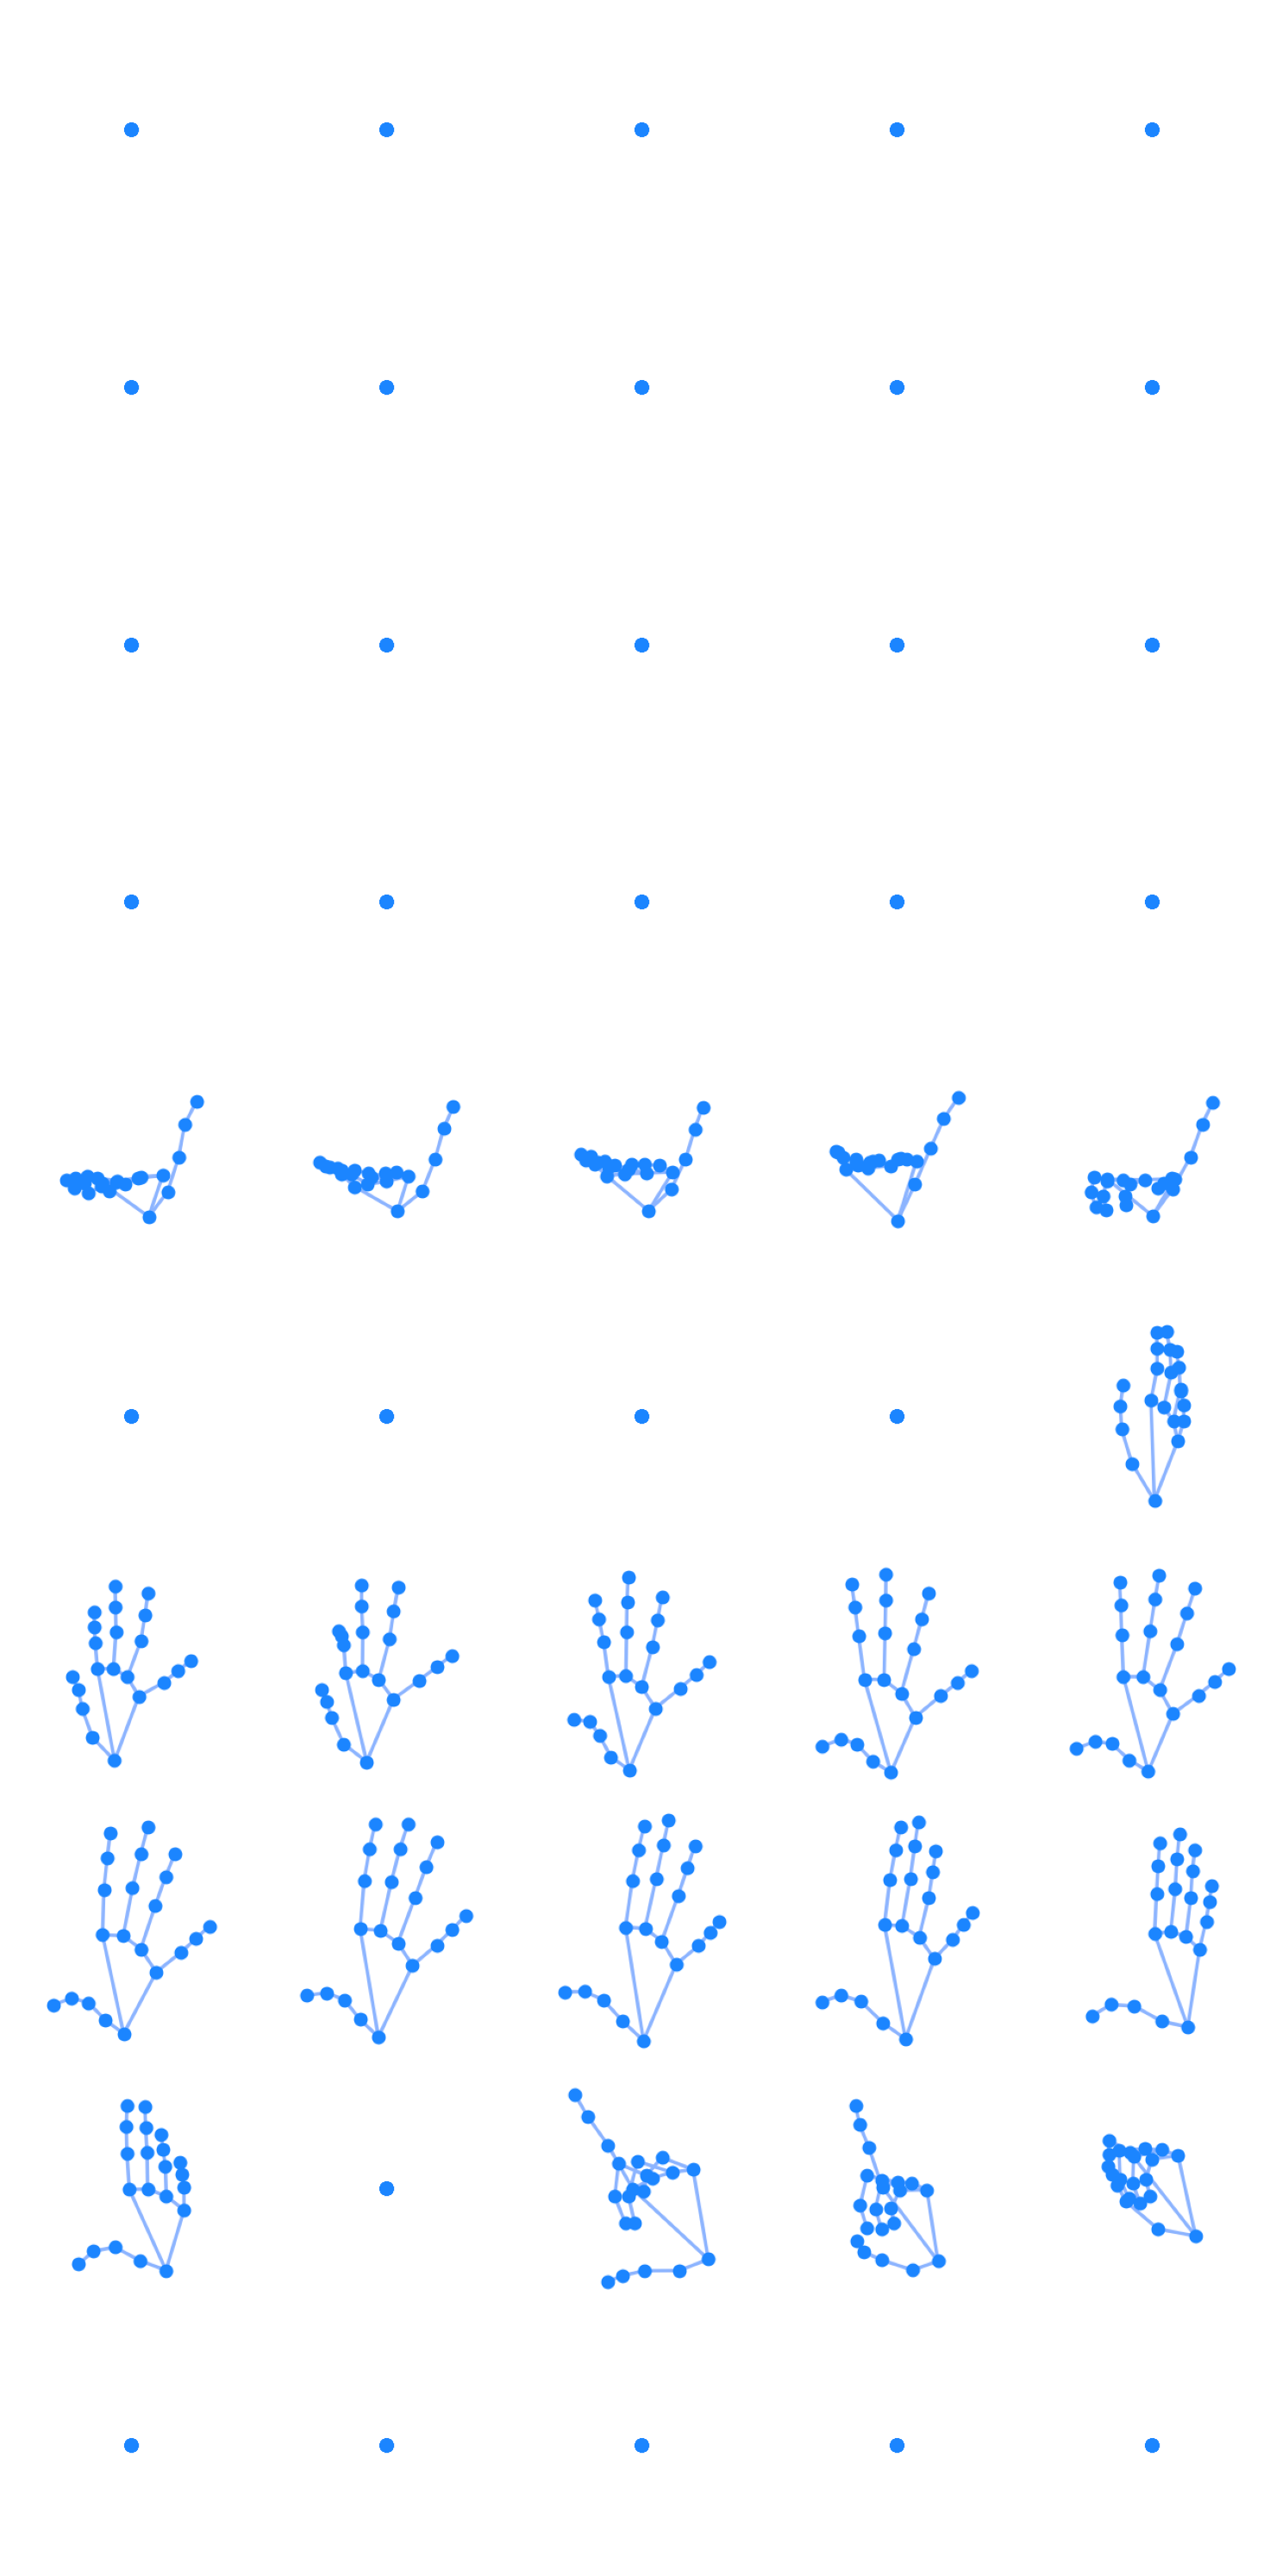

Saved 3 images to righthand_annotation_images


In [28]:
key = "test/01June_2010_Tuesday_heute-6603"

righthand_frames, keypoints, data = show_part_keypoints(
    test_data[key],
    key,
    "righthand",
    canvas_size=(64, 64),
    line_width=0.5,
    point_radius=1,
    start_idx=0,
    end_idx=-1,
)
save_part_images(righthand_frames, "righthand", idxs=[20, 30, 43])


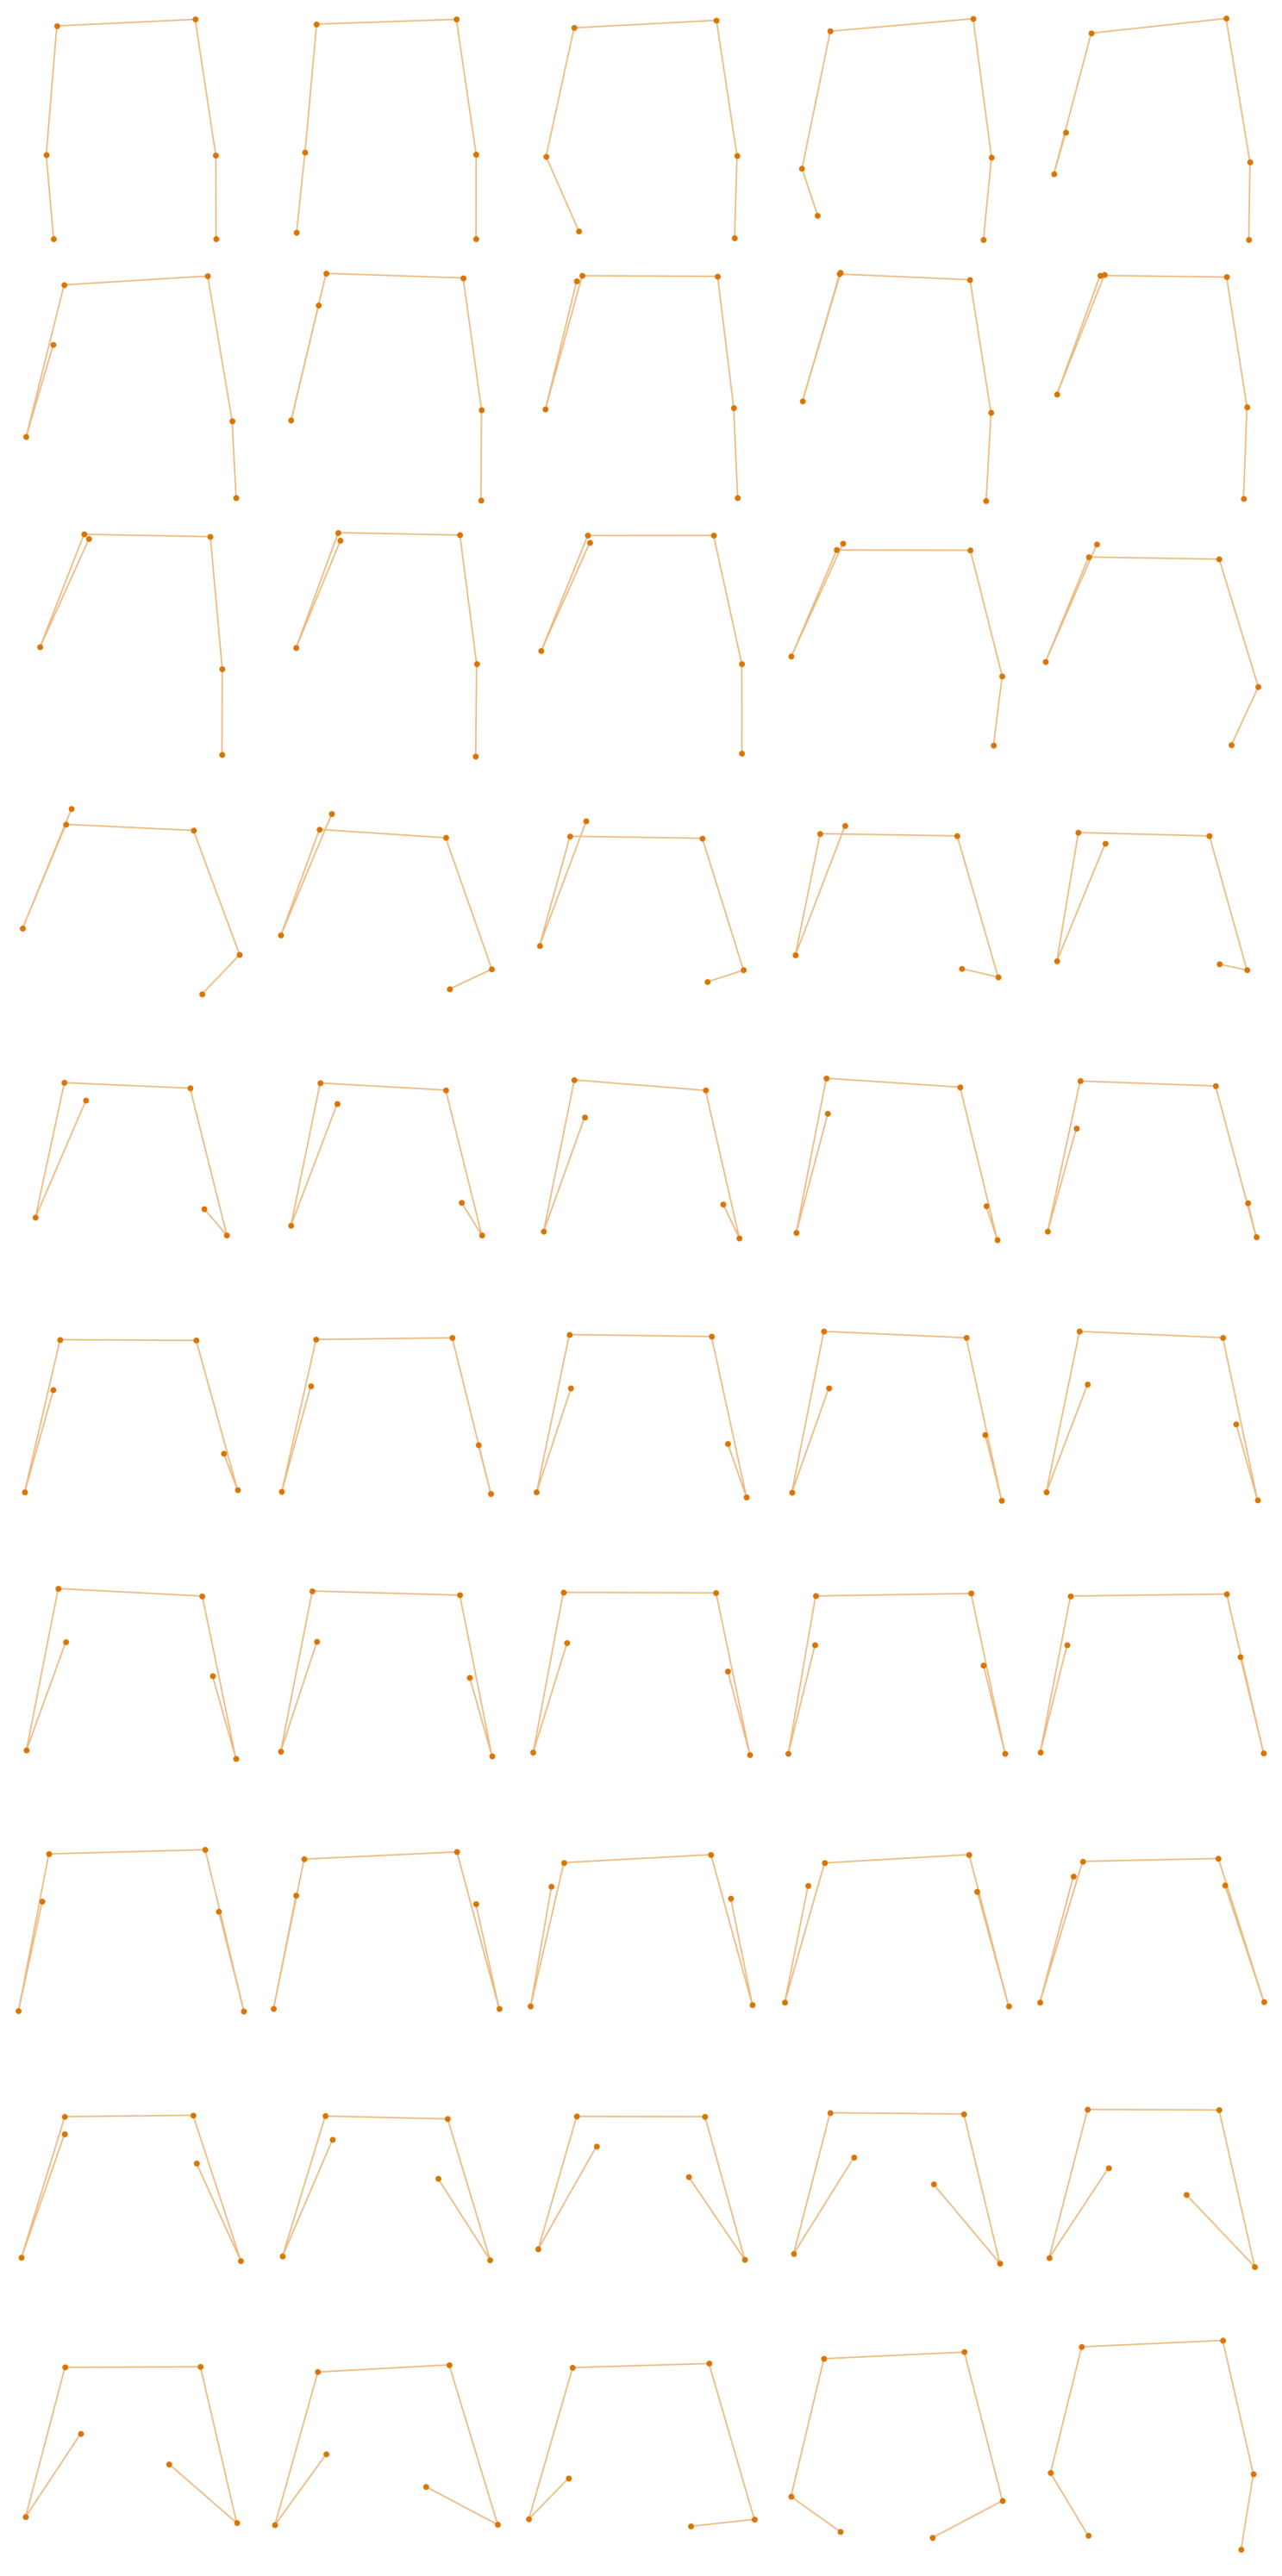

Saved 3 images to body_annotation_images


In [29]:
key = "test/01June_2010_Tuesday_heute-6603"

body_frames, keypoints, data = show_part_keypoints(
    test_data[key],
    key,
    "body",
    canvas_size=(150, 150),
    line_width=0.5,
    point_radius=1,
    start_idx=0,
    end_idx=-1,
)
save_part_images(body_frames, "body", idxs=[20, 30, 43])


Error processing frame 0: 'all'
Error processing frame 1: 'all'
Error processing frame 2: 'all'
Error processing frame 3: 'all'
Error processing frame 4: 'all'
Error processing frame 5: 'all'
Error processing frame 6: 'all'
Error processing frame 7: 'all'
Error processing frame 8: 'all'
Error processing frame 9: 'all'
Error processing frame 10: 'all'
Error processing frame 11: 'all'
Error processing frame 12: 'all'
Error processing frame 13: 'all'
Error processing frame 14: 'all'
Error processing frame 15: 'all'
Error processing frame 16: 'all'
Error processing frame 17: 'all'
Error processing frame 18: 'all'
Error processing frame 19: 'all'
Error processing frame 20: 'all'
Error processing frame 21: 'all'
Error processing frame 22: 'all'
Error processing frame 23: 'all'
Error processing frame 24: 'all'
Error processing frame 25: 'all'


C:\Users\ad\AppData\Local\Temp\ipykernel_6976\1189711766.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


Error processing frame 26: 'all'
Error processing frame 27: 'all'
Error processing frame 28: 'all'
Error processing frame 29: 'all'
Error processing frame 30: 'all'
Error processing frame 31: 'all'
Error processing frame 32: 'all'
Error processing frame 33: 'all'
Error processing frame 34: 'all'
Error processing frame 35: 'all'
Error processing frame 36: 'all'
Error processing frame 37: 'all'
Error processing frame 38: 'all'
Error processing frame 39: 'all'
Error processing frame 40: 'all'
Error processing frame 41: 'all'
Error processing frame 42: 'all'
Error processing frame 43: 'all'
Error processing frame 44: 'all'
Error processing frame 45: 'all'
Error processing frame 46: 'all'
Error processing frame 47: 'all'
Error processing frame 48: 'all'
Error processing frame 49: 'all'


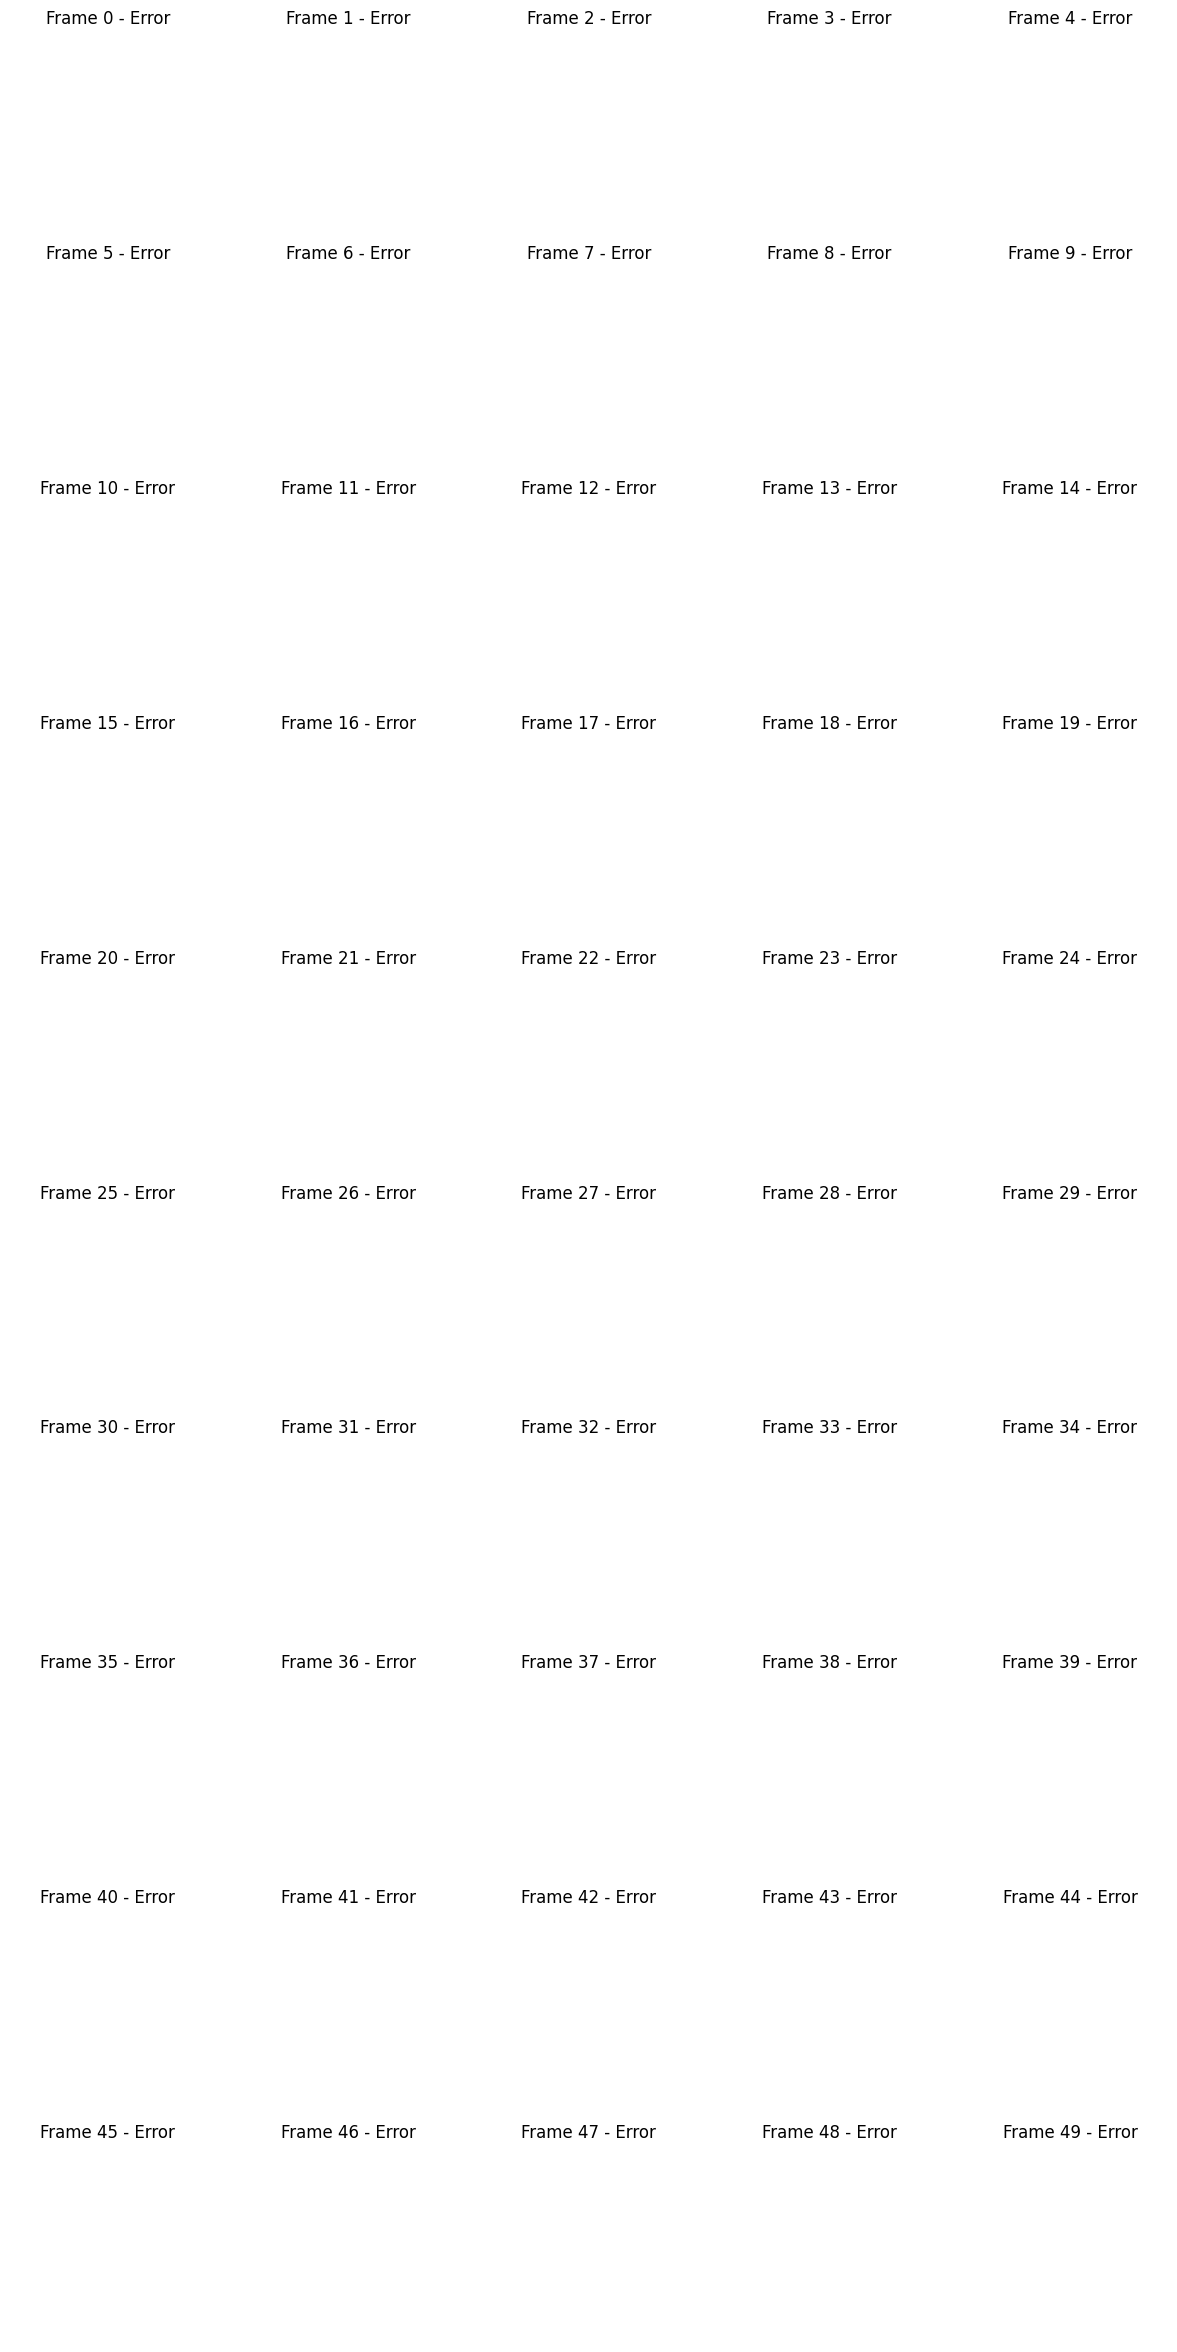

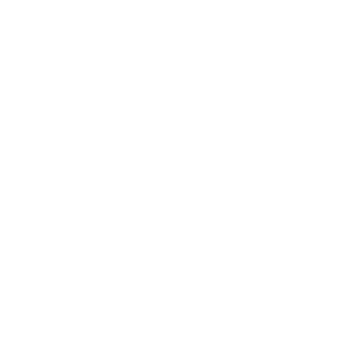

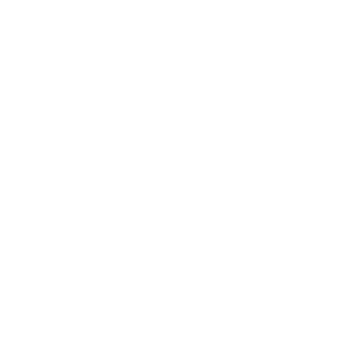

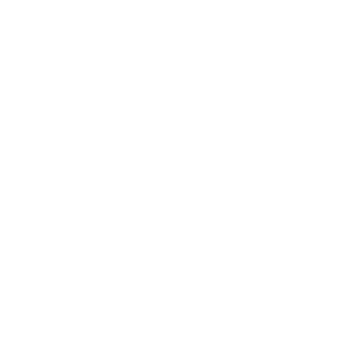

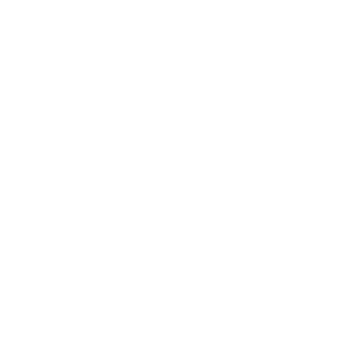

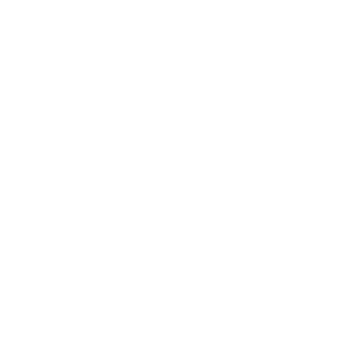

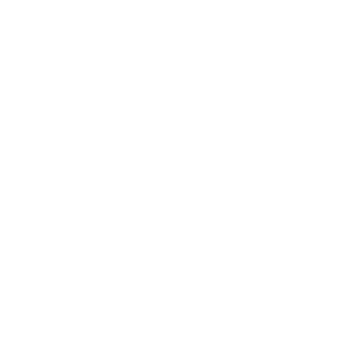

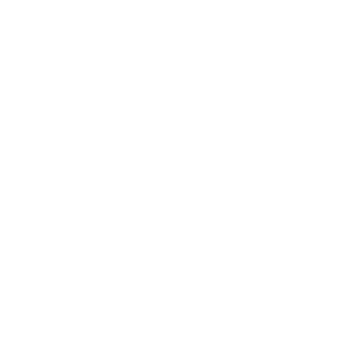

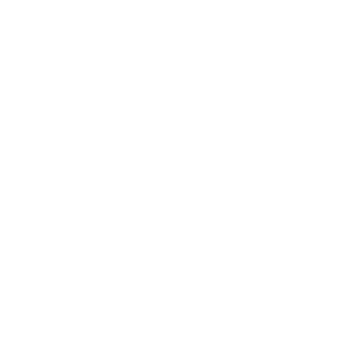

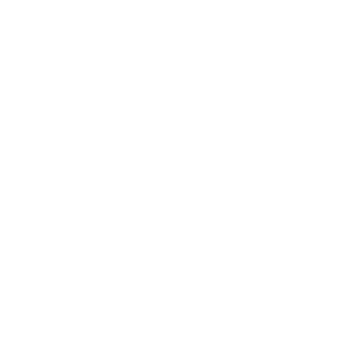

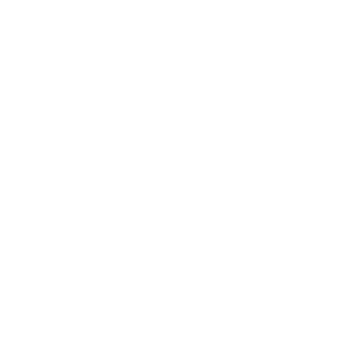

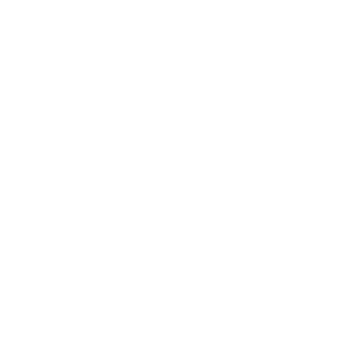

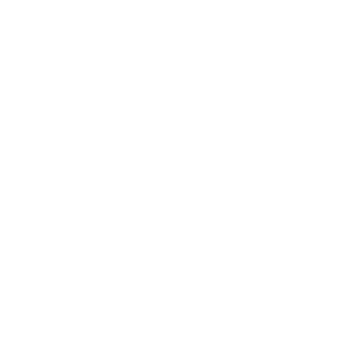

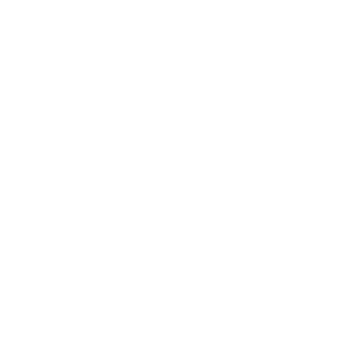

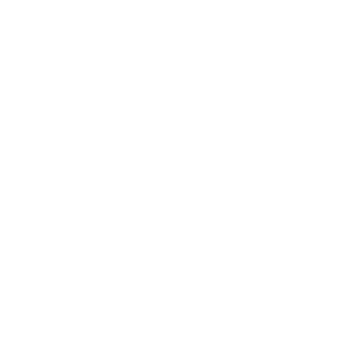

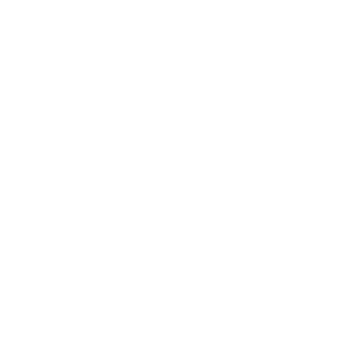

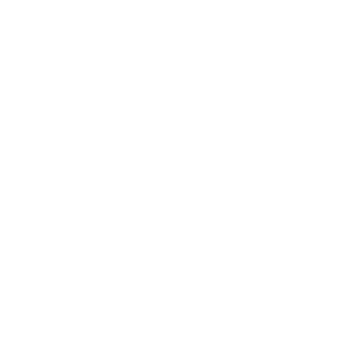

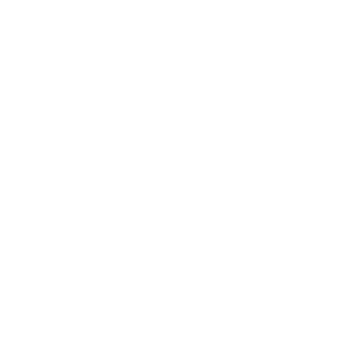

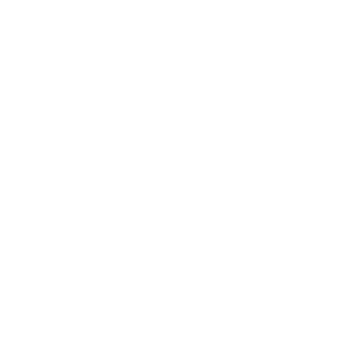

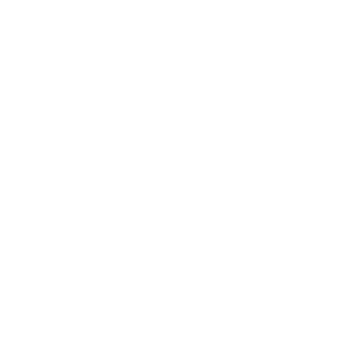

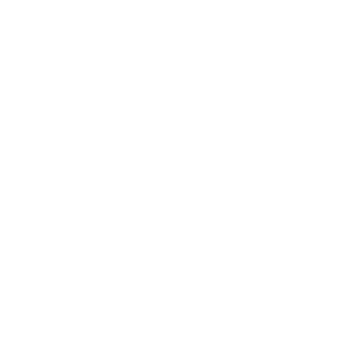

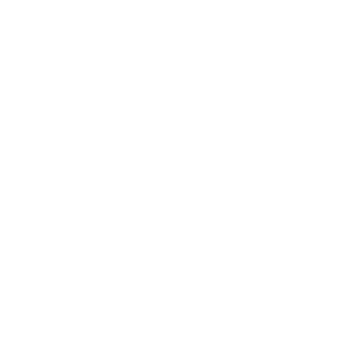

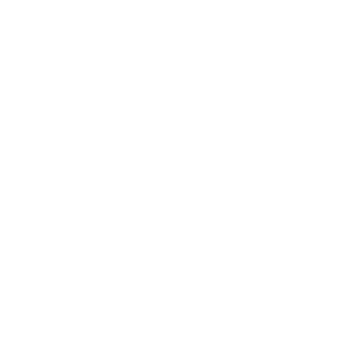

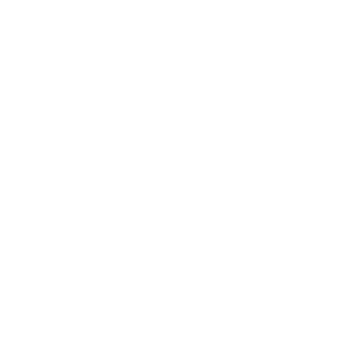

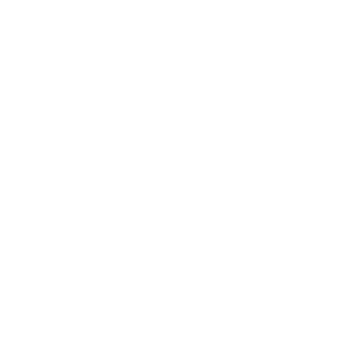

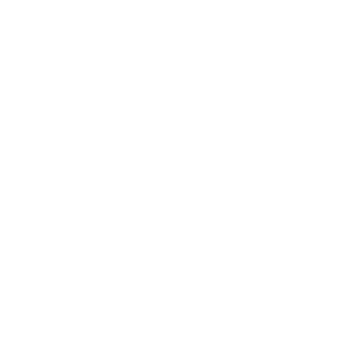

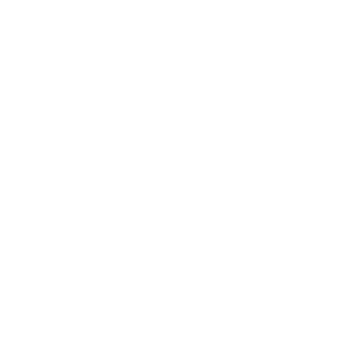

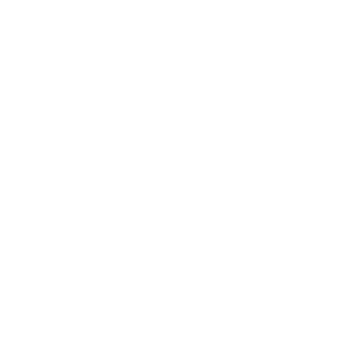

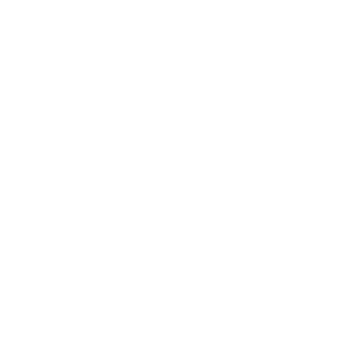

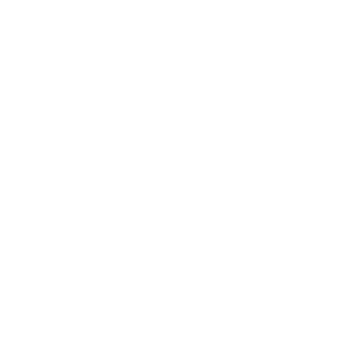

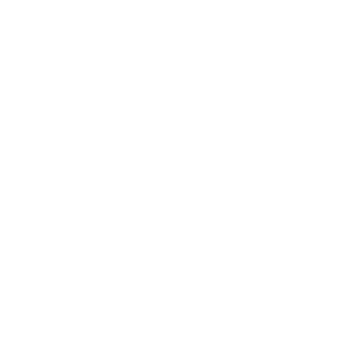

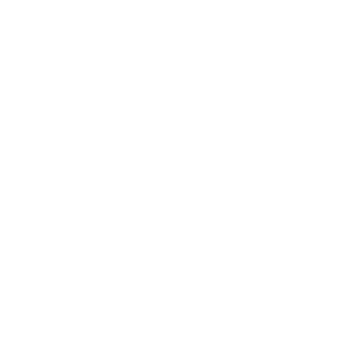

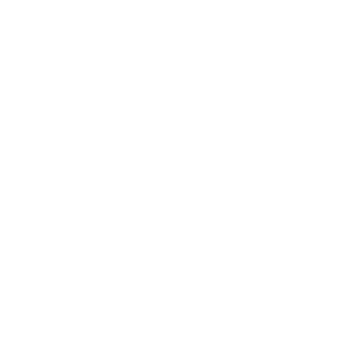

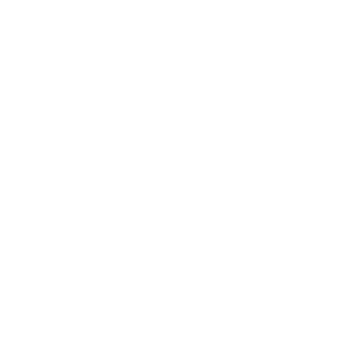

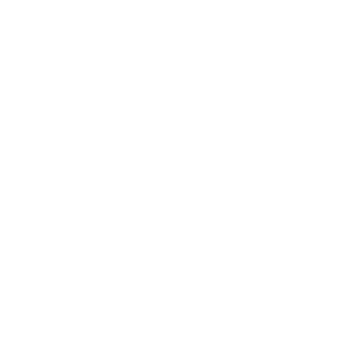

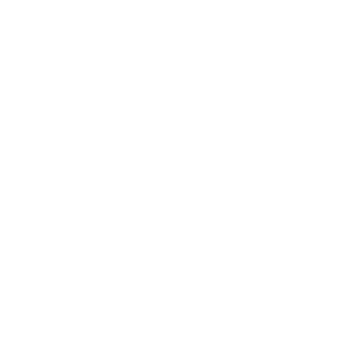

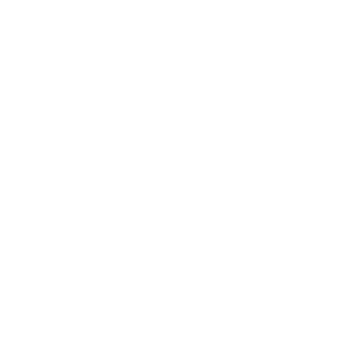

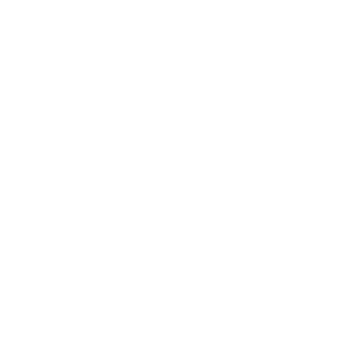

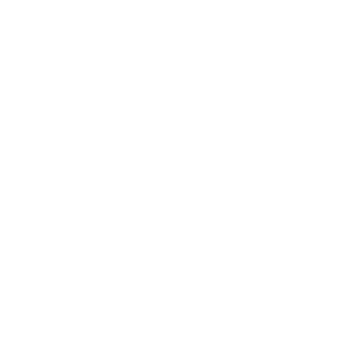

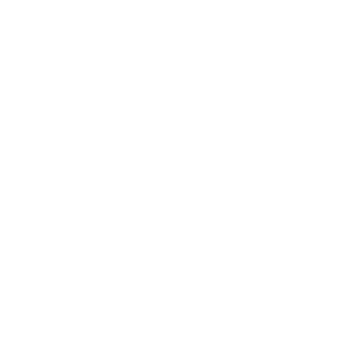

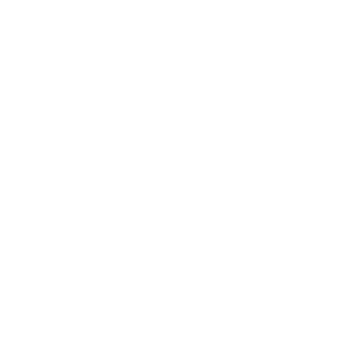

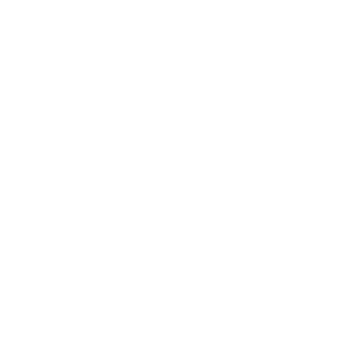

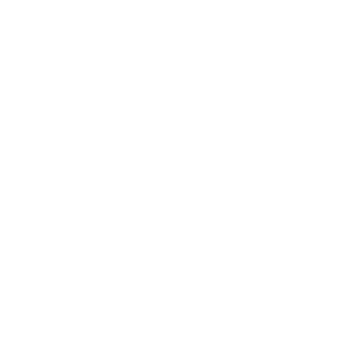

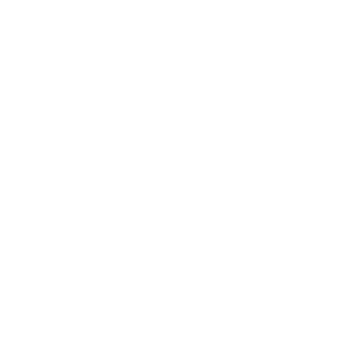

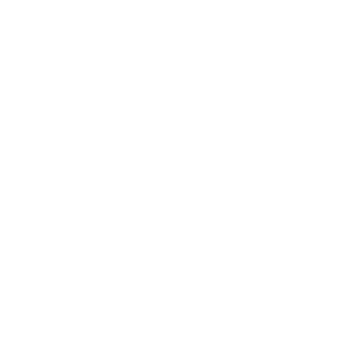

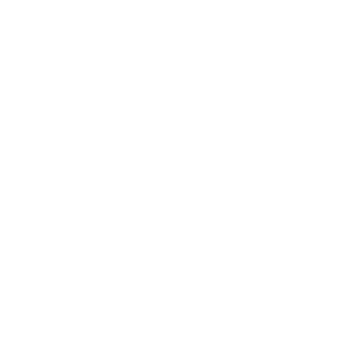

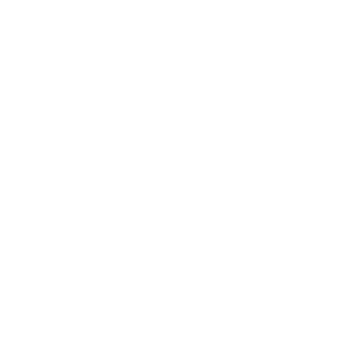

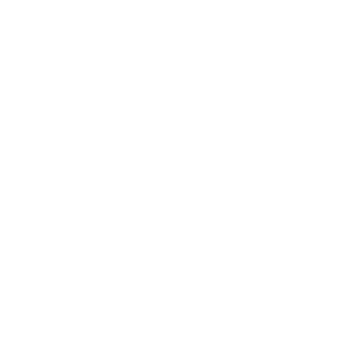

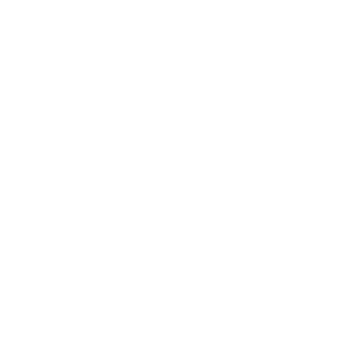

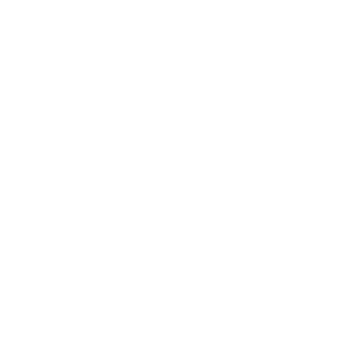

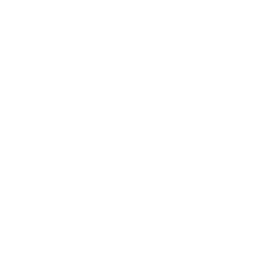

Saved 3 images to all_annotation_images
